In [16]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split

In [17]:
# Define class labels
class_labels = ["Disease Free Leaves", "Leaf Rust", "Leaf Spot"]

In [18]:
# Define dataset path (all images are in one folder)
dataset_dir = "C:/Users/parth/Desktop/Kuppam Clg/Mulberry/Data/Mulberry_Data"  # Update with your dataset folder

In [19]:
# Create temporary train-test split directories
base_dir = "split_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [20]:
# Remove existing directories (if needed)
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for label in class_labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

# Split dataset into train and validation (80% train, 20% validation)
for label in class_labels:
    label_dir = os.path.join(dataset_dir, label)
    images = os.listdir(label_dir)
    
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
    for img in train_images:
        shutil.copy(os.path.join(label_dir, img), os.path.join(train_dir, label, img))
        
    for img in val_images:
        shutil.copy(os.path.join(label_dir, img), os.path.join(val_dir, label, img))

In [21]:
# Image preprocessing
img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 872 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


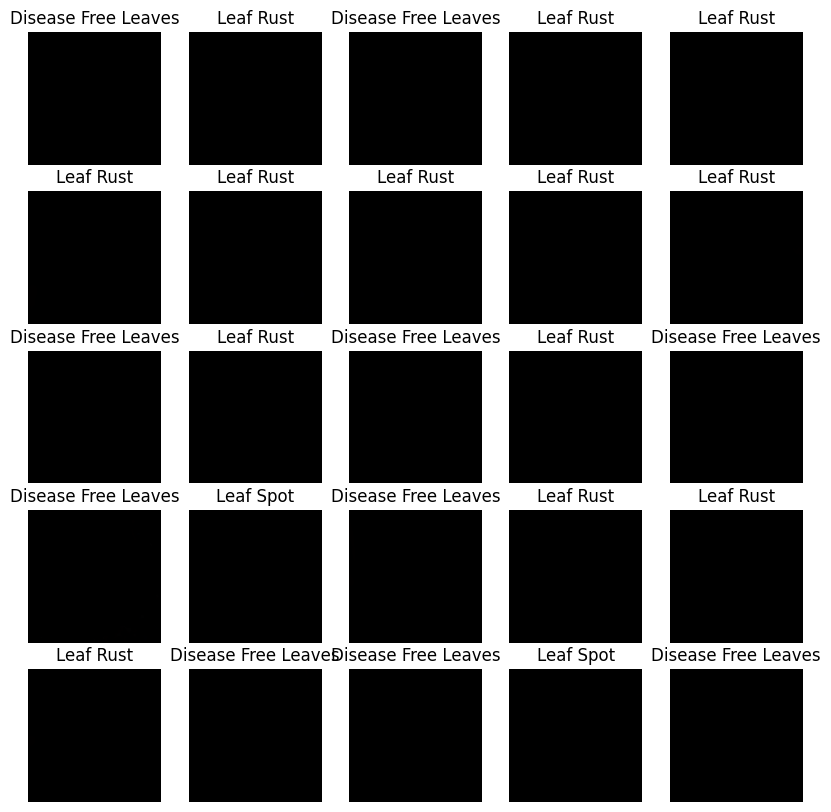

In [22]:
import numpy as np
def display_sample_images(generator, class_names):
    x, y = next(generator)
    plt.figure(figsize=(10, 10))
    
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        
        # Check if image has 3 channels
        if x[i].shape[-1] == 3:
            plt.imshow(x[i].astype("uint8"))  # RGB image
        else:
            plt.imshow(x[i].squeeze(), cmap="white")  # Grayscale
        
        plt.title(class_names[np.argmax(y[i])])
        plt.axis("off")

    plt.show()

# Call the function
class_names = list(train_generator.class_indices.keys())
display_sample_images(train_generator, class_names)


In [9]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])
# print model summary to verify
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,203 (72.61 MB)

 Trainable params: 19,035,203 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train model
epochs = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

C:\Users\parth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 345s 12s/step - accuracy: 0.5714 - loss: 1.3754 - val_accuracy: 0.8174 - val_loss: 0.3917
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 255s 9s/step - accuracy: 0.7755 - loss: 0.5263 - val_accuracy: 0.8219 - val_loss: 0.3801
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 252s 9s/step - accuracy: 0.8085 - loss: 0.4266 - val_accuracy: 0.8813 - val_loss: 0.3409
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 263s 9s/step - accuracy: 0.8438 - loss: 0.3697 - val_accuracy: 0.8813 - val_loss: 0.2909
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 243s 9s/step - accuracy: 0.8751 - loss: 0.3214 - val_accuracy: 0.9041 - val_loss: 0.2634
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 286s 10s/step - accuracy: 0.8570 - loss: 0.3382 - val_accuracy: 0.8904 - val_loss: 0.2282
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 606s 22s/step - accuracy: 0.8821 - loss: 0.2704 - val_accuracy: 0.9178 - val_loss: 0.2005
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 742s 27s/step - accuracy: 0.9120 - loss: 0.2138 - val_accuracy: 0.9178

In [12]:
# Save trained model
model.save("mulberry_leaf_model.h5")

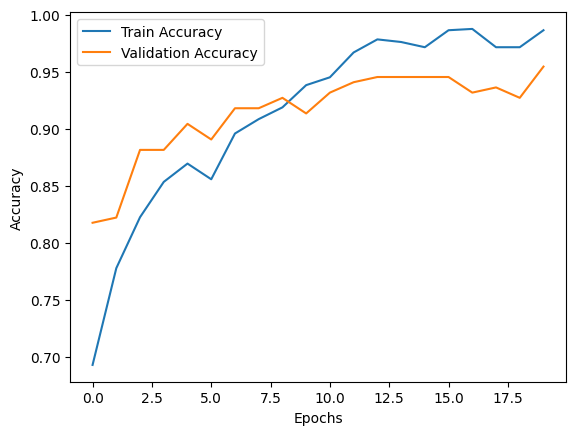

In [13]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


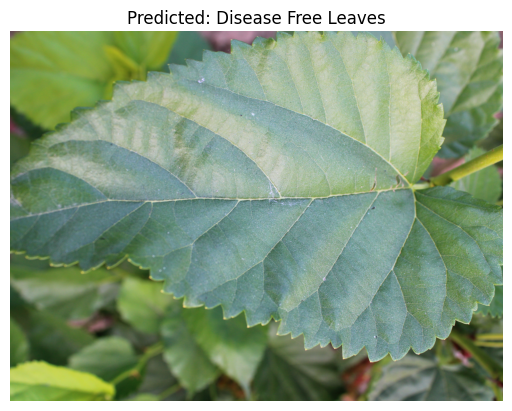

Prediction: Disease Free Leaves
Recommendation: Your plant is healthy! Maintain good watering and sunlight conditions.



In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

# Define class labels and recommendations
class_labels = ["Disease Free Leaves", "Leaf Rust", "Leaf Spot"]
recommendations = {
    "Disease Free Leaves": "Your plant is healthy! Maintain good watering and sunlight conditions.",
    "Leaf Rust": "Use a fungicide spray. Remove infected leaves and avoid overhead watering.",
    "Leaf Spot": "Trim affected leaves, ensure good air circulation, and apply copper-based fungicide."
}

# Load trained model
model = load_model("mulberry_leaf_model.h5")  # Ensure correct model file name

def preprocess_image(img_path):
    """Preprocess image for model prediction."""
    img = load_img(img_path, target_size=(150, 150))  # Resize image
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

def predict_leaf_disease(img_path):
    """Predict the disease from the image."""
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]
    recommendation = recommendations[predicted_label]
    
    # Show image with prediction
    img = load_img(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}")
    plt.show()
    
    print(f"Prediction: {predicted_label}")
    print(f"Recommendation: {recommendation}\n")

# Manual testing using file selection dialog
def select_image():
    """Open file dialog to select an image and test prediction."""
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    if file_path:
        predict_leaf_disease(file_path)

# GUI for selecting an image
root = tk.Tk()
root.withdraw()  # Hide the main window
select_image()
